# Le RNN avec Pytorch

Dans ce notebook, vous allez découvrir comment utiliser le RNN avec Pytorch pour résoudre un problème de série temporelle.

Le but sera de prédire la température de Delhi au cours du temps.

Vous pouvez retrouver le jeu de donneés sur [Kaggle](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data).

# Importation des packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch as torch
from torch.utils.data import Dataset
from torchsummary import summary

import matplotlib.pyplot as plt

# Importation des données

J'ai hébergé les données sur mon compte Google Drive pour vous permettre de gagner du temps et de ne pas devoir les charger sur votre session Google Colab.

Vous avez seulement à ajouter un raccourci de mon Drive au votre, puis à lier votre compte Google Colab à votre compte Google Drive pour avoir accès aux données.

Les données ne seront en aucun cas sur votre Drive, seul un raccourci où se situe les données sera présent.

### Lier les données à votre Drive

Lien du drive:

https://drive.google.com/drive/folders/1oYQazCKVZZiCPVP6z9R37NHtXy-faBhy?usp=sharing

**Cliquez** sur le lien.

**Cliquez** droit sur le dossier *delhi_climate* comme sur la photo ci-dessous.

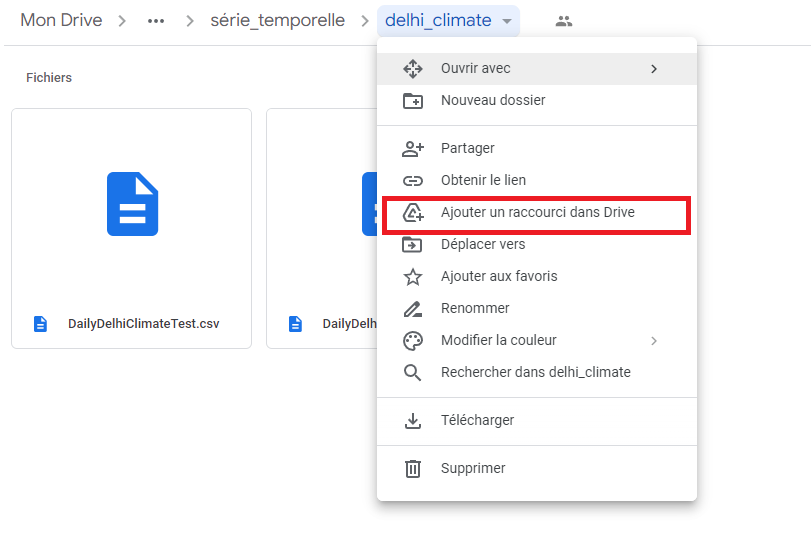

**Cliquez** sur l'option *Ajouter un raccourci dans Drive*.

## Lier votre compte Google Colab à votre Drive

**Exécutez** la cellule ci-dessous pour lier votre compte Google Drive à votre session Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/delhi_climate/DailyDelhiClimateTrain.csv')
train.head()

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/delhi_climate/DailyDelhiClimateTest.csv')
test.head()

# Analyse du jeu de données

##Statistiques descriptives

In [ ]:
train.describe()

On peut remarquer des outliers dans la mesure de la pression pour le jeu d'entraînement.

In [ ]:
test.describe()

## Données manquantes

Checkez s'il y a des valeurs manquantes.

In [ ]:
train.isna().sum()

In [ ]:
test.isna().sum()

Aucune données manquantes.

## Gestion des outliers

In [ ]:
train['meanpressure'].sort_values()

Si une valeur est plus grande que la moyenne plus 1.5 fois l'écart type on remplace cette valeur par la valeur moyenne plus 1.5 fois l'écart type.

In [ ]:
train['meanpressure'] = np.where(train['meanpressure']>train['meanpressure'].median()+train['meanpressure'].std()*1.5,
                                 train['meanpressure'].median()+train['meanpressure'].std()*1.5,
                                 train['meanpressure'])

Si une valeur est plus petite que la moyenne moins 1.5 fois l'écart type on remplace cette valeur par la valeur moyenne moins 1.5 fois l'écart type.

In [ ]:
train['meanpressure'] = np.where(train['meanpressure']<train['meanpressure'].median()-train['meanpressure'].std()*1.5,
                                 train['meanpressure'].median()+train['meanpressure'].std()*1.5,
                                 train['meanpressure'])

## Visualisation des distributions

In [ ]:
plt.boxplot(x=train['meantemp'])
plt.show()

In [ ]:
plt.boxplot(x=train['humidity'])
plt.show()

In [ ]:
plt.boxplot(x=train['wind_speed'])
plt.show()

In [ ]:
plt.boxplot(x=train['meanpressure'])
plt.show()

## Visualisation des séries temporelles

In [ ]:
plt.figure(figsize=(100,80))
fig, axs = plt.subplots(2, 2,figsize=(20,20))
axs[0, 0].plot(train['date'],train['meantemp'])
axs[0, 0].set_title('Mean temp')
axs[0, 1].plot(train['date'],train['humidity'], 'tab:orange')
axs[0, 1].set_title('Humidity')
axs[1, 0].plot(train['date'],train['wind_speed'], 'tab:green')
axs[1, 0].set_title('Wind Speed')
axs[1, 1].plot(train['date'],train['meanpressure'], 'tab:red')
axs[1, 1].set_title('MeanPressure')
plt.show()

# Pré traitement des données

Standardisation du jeu d'entraînement.

In [ ]:
scaler_train = StandardScaler()

scaler_train.fit(train.loc[:, ["meantemp", "humidity",
                               "wind_speed", "meanpressure"]])

train_norm = train.copy()

train_norm.loc[:, ["meantemp", "humidity",
                   "wind_speed", "meanpressure"]] = scaler_train.transform(train.loc[:, ["meantemp", "humidity",
                                                                                         "wind_speed", "meanpressure"]])

test_norm = test.copy()

test_norm.loc[:, ["meantemp", "humidity",
                  "wind_speed", "meanpressure"]] = scaler_train.transform(test.loc[:, ["meantemp", "humidity",
                                                                                       "wind_speed", "meanpressure"]])

# Création du jeu d'entraînement temporel

Création du jeu de données de série temporelle avec les historiques pour chaque prédiction.

In [ ]:
def create_temporal_dataset(df:pd.DataFrame, target:str, look_back:int=2) -> np.array:
  ''' Create a temporal dataset to predict the y a previous number of terms equal to look_back'''

  # Initialisation of the explaniables variables dataset
  x = np.zeros([df.shape[0]-look_back, look_back, df.shape[1]])
  # Initialisation of the target dataset
  y = np.zeros([df.shape[0]-look_back, 1])

  # For every target value search expainables variables for a number of terms equal to look_back
  for i in range(len(df)-look_back):
      # update x and y
      x[i, :, :] = df.iloc[i:(i+look_back), :]
      y[i, :] = df.loc[(i+look_back), target]
  return x, y

Pour prédire la prochaine température, on décide de prendre 3 jours d'historiques.

In [ ]:
x_train, y_train = create_temporal_dataset(train_norm.sort_values('date').drop('date', axis=1), 'meantemp', 3)

In [ ]:
x_train.shape

In [ ]:
x_test, y_test = create_temporal_dataset(test_norm.sort_values('date').drop('date', axis=1), 'meantemp', 3)

In [ ]:
x_test.shape

## Création du générateur

Cette fonction permet de créer un générateur Pytorch adapter à la problématique.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, x_train, y_train):
        self.input = x_train
        self.output = y_train

    def __len__(self):
        return len(self.output)

    def __getitem__(self, idx):
        batch_input = self.input[idx, :, :]
        batch_output = self.output[idx, :]

        return batch_input, batch_output

In [ ]:
x_training = CustomDataset(torch.from_numpy(np.float32(x_train)),
                                 torch.from_numpy(np.float32(y_train)))

Utilisez la fonction `DataLoader` avec `x_training` et un batch de 32.

In [ ]:
dataloader_train = None

Checkez les dimensions des batchs générés.

In [ ]:
for x, y in dataloader_train:
  print(x.shape)
  print(y.shape)
  break

In [ ]:
x_testing = CustomDataset(torch.from_numpy(np.float32(x_test)),
                                 torch.from_numpy(np.float32(y_test)))

Utilisez la fonction `DataLoader` avec `x_training` et un batch de `len(x_testing)`.

In [ ]:
dataloader_test = None

Checkez les dimensions des données.

In [ ]:
for x, y in dataloader_test:
  print(x.shape)
  print(y.shape)
  break

# Entraînement du modèle

Fonction d'entraînement.

In [ ]:
def step(model:torch.nn.Sequential,
         opt:torch.optim,
         criterion:torch.nn.modules.loss,
         x_train:torch.Tensor,
         y_train:torch.Tensor)->tuple:
  """
  Executes a single training step for a PyTorch model.
  This function performs a forward pass to compute the model's predictions, calculates
  the loss between predictions and actual target values, computes gradients for each
  model parameter, and updates the parameters using the optimizer.

  Args:
      model (torch.nn.Sequential): The PyTorch model to train.
      optimizer (torch.optim.Optimizer): Optimizer used to update the model's parameters.
      criterion (torch.nn.modules.loss._Loss): Loss function used to compute the error.
      x_train (torch.Tensor): Input training data (features).
      y_train (torch.Tensor): Ground truth labels or target values for the training data.
  Returns:
      tuple: The updated model and the computed loss for the current step.
  """

  # Réinitialisez les gradients d'optimizer à zéro avec la méthode 'zero_grad'
  opt.zero_grad()

  # Calculez les prédiction sur le jeu d'entraînement avec la méthode 'froward'
  prediction = model.forward(x_train)

  # Calculez l'erreur de prédiction avec 'criterion'
  loss = criterion(prediction, y_train)

  # Calculez les gradients avec la méthode 'backward'
  loss.backward()

  # Mettre à jour les paramètres du modèle avec la méthode 'step'
  opt.step()

  return model, loss

In [ ]:
def fit(model, optimizer, criterion, epoch, trainloader, testloader):
    epoch = epoch
    history_train_loss = []
    history_test_loss = []

    for e in range(epoch) :

      train_loss_batch = 0
      test_loss_batch = 0

      for images, labels in trainloader:

        # mise à jour des poids avec la fonction 'step'
        model, train_loss = step(model, optimizer, criterion, images, labels)

        train_loss_batch += train_loss.detach().numpy()


      for images, labels in testloader:

        prediction = model.forward(images)

        test_loss = criterion(prediction, labels)

        test_loss_batch += test_loss.detach().numpy()

      train_loss_batch /= len(trainloader.sampler)
      test_loss_batch /= len(testloader.sampler)

      # Sauvegarde des coûts d'entraînement avec append
      history_train_loss = np.append(history_train_loss, train_loss_batch)
      history_test_loss = np.append(history_test_loss, test_loss_batch)

      print(f'epoch : {e}/{epoch}')
      print('train_loss : '+str(np.squeeze(train_loss_batch))+ ' test_loss : '+str(np.squeeze(test_loss_batch)))
      print('-------------------------------------------------------------------------------------------------')

    return model, history_train_loss, history_test_loss


## Initialisation du modèle

**Utilisez** la fonction `Sequential` pour initialiser le modèle suivant:
- une couche de RNN avec en utilisant les paramètres de `__init__` et avec batch_first à True.
- une couche linéaire en utilisant les paramètres `__init__`.


Pour la fonction `forward`:
- D'abord initialiser `h0` qui est un vecteur de 0.
- Ensuite utiliser `self.rnn`
- Enfin utiliser `self.fc` en prenant seulement la dernière sortie de `out`.

In [ ]:
# Définir le modèle RNN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = None
        self.num_layers = None

        # Couche RNN
        self.rnn = None

        # Couche entièrement connectée pour la sortie
        self.fc = None

    def forward(self, x):
        # Initialiser l'état caché avec des zéros
        h0 = None

        # Passer les données dans la couche RNN
        out, h_n = None

        # Prendre la dernière sortie de la séquence
        out = None
        return out

Utilisez la fonction `RNNModel` pour initialiser le modèle.

In [ ]:
# Définir les dimensions d'entrée et de sortie
input_size = 4
hidden_size = 20
num_layers = 1
output_size = 1

# Initialiser le modèle
model = None

## Visualisation du modèle

**Utilisez** la fonction `summary` pour visualiser votre modèle.

In [ ]:
None

## Compilation du modèle

Initialisez `criterion` avec la fonction `NLLLoss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [ ]:
criterion = None
optimizer = None

## Entraînement du modèle

Utilisez la fonction `fit` pour entraîner le modèle.

In [ ]:
epoch = 100

In [ ]:
model, history_train_loss, history_test_loss = None

## Visualisation des performances d'entraînement

In [ ]:
loss = history_train_loss
val_loss = history_test_loss

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Mean Square Error')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Visualisation des données de test

**Utilisez** la méthode `forward` pour obtenir les prédictions sur le jeu de données de test.

In [ ]:
for x, y in dataloader_test:
  pred = None
  break

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(y, color = 'black', label = 'Delhi Mean Temperature')
plt.plot(pred, color = 'green', label = 'Predicted Delhi Mean Temperature')
plt.title('Delhi Mean Temp Prediction')
plt.xlabel('Time')
plt.ylabel('Mean Temp')
plt.legend()
plt.show()